## Customer Segmentation

### Table of Contents:
1. Data Preparation
2. Exploring the content of variables
3. Insight on Market Analysis
4. customer categories
5. Classification of customers using K-Means
6. conclusion 

### 1. Data Preparation

As a first step, load all the modules that will be used in this notebook:

In [75]:
import pandas as pd 
import sqlite3 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

Once done, let's explore some basic information on the content of the dataframe: the type of the various variables, the number of null values and their percentage with respect to the total number of entries:

In [2]:
# making connection to the database 
conn=  sqlite3.connect("./Data/bootcamp_db")
conn

In [3]:
sql_query = """SELECT name 
                FROM sqlite_master 
                where type = 'table';"""

In [4]:
cursor = conn.cursor()

In [5]:
cursor.execute(sql_query)

In [6]:
print(f"list of tables in the database:\n{cursor.fetchall()}")

list of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


In [7]:
#query that loding online _transactions table in to the online_transactions variable
query = """ select * 
            from online_transactions"""
online_transactions = pd.read_sql(query,conn)


In [8]:
online_transactions


,invoice,stock_code,quantity,invoice_date,price,customer_id,country
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom
...,...,...,...,...,...,...,...
541905,581580,22698,1,2011-12-09 12:20:00,2.95,u12748,United Kingdom
541906,581584,20832,72,2011-12-09 12:25:00,0.72,u13777,United Kingdom
541907,581585,22178,12,2011-12-09 12:31:00,1.95,u15804,United Kingdom
541908,581585,84692,25,2011-12-09 12:31:00,0.42,u15804,United Kingdom


In [9]:
# query that loading stock_description table in to stock_description variable
query= """select *
        from stock_description"""
stock_description = pd.read_sql(query,conn)

In [10]:
stock_description

,stock_code,description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10120,DOGGY RUBBER
3,10123C,HEARTS WRAPPING TAPE
4,10124A,SPOTS ON RED BOOKCOVER TAPE
...,...,...
3947,DCGSSGIRL,GIRLS PARTY BAG
3948,DOT,DOTCOM POSTAGE
3949,PADS,PADS TO MATCH ALL CUSHIONS
3950,POST,POSTAGE


In [11]:
# cleaning the data 
query="""select ot.invoice,
                  ot.stock_code,
             CASE
                when description IS NULL then 'Unknown'
                else description
                end as description,
                ot.price * ot.quantity  as total_cost,
                ot.invoice_date,
                ot.price,
                ot.quantity,
                ot.customer_id,
                ot.country
              from online_transactions ot
              left join (select * 
                          from stock_description 
                            where description <> '?' ) sd on ot.stock_code = sd.stock_code
             where  ot.customer_id <> ''
             and ot.stock_code not in ('BANK CHARGES', 'POST', 'D', 'M', 'CRUK')"""

In [12]:
ot_clean=pd.read_sql(query,conn)

In [13]:
ot_clean

,invoice,stock_code,description,total_cost,invoice_date,price,quantity,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,30.00,2010-12-01 08:45:00,1.25,24,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,15.30,2010-12-01 09:02:00,2.55,6,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,19.50,2010-12-01 09:37:00,1.95,10,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,2010-12-01 09:41:00,2.95,1,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,11.90,2010-12-01 09:41:00,5.95,2,u15311,United Kingdom
...,...,...,...,...,...,...,...,...,...
405058,581580,22698,PINK REGENCY TEACUP AND SAUCER,2.95,2011-12-09 12:20:00,2.95,1,u12748,United Kingdom
405059,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,51.84,2011-12-09 12:25:00,0.72,72,u13777,United Kingdom
405060,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,23.40,2011-12-09 12:31:00,1.95,12,u15804,United Kingdom
405061,581585,84692,BOX OF 24 COCKTAIL PARASOLS,10.50,2011-12-09 12:31:00,0.42,25,u15804,United Kingdom


In [14]:
# the following code gives some info on columns types and numer of null values
tab_info=pd.DataFrame(ot_clean.dtypes).T.rename(index={0:'column type'})
tab_info=pd.concat([tab_info,pd.DataFrame(ot_clean.isnull().sum()).T.rename(index={0:'null values (nb)'})],ignore_index=False)
tab_info=pd.concat([tab_info,pd.DataFrame(ot_clean.isnull().sum()/ot_clean.shape[0]*100).T.
                         rename(index={0:'null values (%)'})],ignore_index=False)
display(tab_info)

,invoice,stock_code,description,total_cost,invoice_date,price,quantity,customer_id,country
column type,object,object,object,float64,object,float64,int64,object,object
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hence, There are no Null values in the Dataframe,let's check with duplicate values, if any, delete them 

In [15]:
#finding duplicates 
print('no. of duplicates:',ot_clean.duplicated().sum())

no. of duplicates: 5222


In [16]:
ot_clean.drop_duplicates(inplace = True)

In [17]:
ot_clean.shape

(399841, 9)

## 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to:

Invoice: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

Stock_code: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

Price: Unit price. Numeric, Product price per unit .

Customer_id: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.


###  2.1 Countries :

 Here, we  quickly look at the countries from which orders were made:

In [18]:
# Grouping by customer_id, invoice, and country
temp = ot_clean[['customer_id', 'invoice', 'country']].groupby(['customer_id', 'invoice', 'country']).count()

# Reset the index to make 'country' a regular column again
temp = temp.reset_index(drop=False)

# Check if 'country' exists in the columns and count the number of unique countries
if 'country' in temp.columns:
    countries = temp['country'].value_counts()
    print('No. of countries: {}'.format(len(countries)))
else:
    print("The 'country' column is not present in the DataFrame.")


No. of countries: 37


In [19]:
# which country has high sales (Top 10)
query = """select country,
                  sum(quantity) as product_sold
           from online_transactions_cleaned 
           group by country 
           order by product_sold desc
           limit 10 """

In [20]:
top10_countries=pd.read_sql(query,conn)

In [21]:
top10_countries

,country,product_sold
0,United Kingdom,3992342
1,Netherlands,200510
2,EIRE,136189
3,Germany,116235
4,France,109019
5,Australia,83643
6,Sweden,35594
7,Switzerland,29681
8,Spain,26611
9,Japan,25221


We see that the dataset is largely dominated by orders made from the UK

### 2.2 Customers and products

The dataframe contains  almost 400,000 entries.
What are the number of users and products in these entries ?

In [22]:
pd.DataFrame([{'Products':len(ot_clean['stock_code'].value_counts()),
               'transactions':len(ot_clean['invoice'].value_counts()),
               'customers':len(ot_clean['customer_id'].value_counts())}],index=['quantity'])

,Products,transactions,customers
quantity,3679,21791,4363


It can be seen that the data concern 4363 users and that they bought 3679 different products. The total number of transactions carried out is of the order of  21791.

Now I will determine the number of products purchased in every transaction:

In [23]:
temp = ot_clean.groupby(by=['customer_id', 'invoice'], as_index=False)['invoice_date'].count()
nb_products_per_basket = temp.rename(columns = {'invoice_date':'Number of products'})
nb_products_per_basket[:10].sort_values('customer_id')

,customer_id,invoice,Number of products
0,u12346,541431,1
1,u12346,C541433,1
2,u12347,537626,31
3,u12347,542237,29
4,u12347,549222,24
5,u12347,556201,18
6,u12347,562032,22
7,u12347,573511,47
8,u12347,581180,11
9,u12348,539318,16


The first lines of this list shows several things worthy of interest:

the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
the existence of users who only came once and only purchased one product (e.g. 12346)
the existence of frequent users that buy a large number of items at each order

### 2.3 Handling Returns 

In [24]:
# let's copy the data into a new dataframe.
new_df = ot_clean.copy()

In [25]:
new_df.shape

(399841, 9)

Let's locate the entries that indicate a negative quantity using the column  'is_return'


In [26]:
new_df['is_return'] = new_df['quantity']<0

In [27]:
# Reverse the effect of returns (if necessary)
new_df['net_quantity']=new_df['quantity'].abs()
new_df['net_revenue'] = new_df['price'].abs()

In [28]:
# Summarize data
total_quantity_sold = new_df[new_df['is_return'] == False]['net_quantity'].sum()
total_returns = new_df[new_df['is_return'] == True]['net_quantity'].sum()
net_revenue = new_df['net_revenue'].sum()

In [29]:
# Reporting
print(f"Total quantity sold: {total_quantity_sold}")
print(f"Total returns: {total_returns}")
print(f"Net revenue: ${net_revenue}")

Total quantity sold: 5155512
Total returns: 267712
Net revenue: $1180696.273


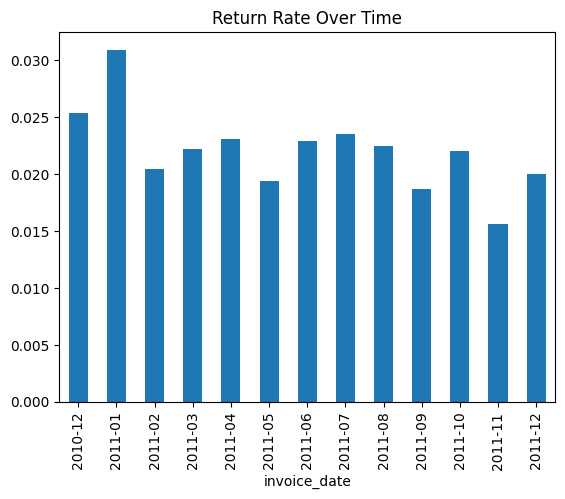

In [30]:
# Return rates over time (assuming we have a date field)
new_df['invoice_date'] = pd.to_datetime(new_df['invoice_date'])
new_df.groupby(new_df['invoice_date'].dt.to_period('M'))['is_return'].mean().plot(kind='bar')
plt.title('Return Rate Over Time')
plt.show()

 Data Integration, involves merging return transactions with the original sales data to ensure that the analysis accurately reflects the impact of returns. This is especially important if you need to match specific returns to their corresponding sales transactions.

Purpose of Data Integration The goal is to link each return transaction with its original sales transaction to:

Correctly attribute returns to the correct sale.
Analyze the impact of returns on the original sales.
Ensure accurate calculation of metrics like net sales, customer behavior, and product performance.

In [31]:
sales_df = new_df[new_df['quantity']>0]
return_df= new_df[new_df['quantity']<0]

In [32]:
sales_df.shape[0]

391334

In [33]:
return_df.shape[0]

8507

In [34]:
# Normalisation 
return_df['quantity'] = return_df['quantity'].abs()
return_df['price'] = return_df['price'].abs()

In [35]:
# match returns to sales 
merged_df = pd.merge(sales_df,return_df,on=['customer_id','stock_code'],how='left',suffixes=('_sale', '_return'))

In [36]:
merged_df.shape[0]

397115

In [37]:
# Handle multiple returns 
returns_grouped_df = return_df.groupby(['customer_id','stock_code']).agg({
    'quantity': 'sum',
    'price': 'sum'
}).reset_index()
merged_df = pd.merge(sales_df, returns_grouped_df, on=['customer_id','stock_code'], how='left', suffixes=('_sale', '_return'))

In [38]:
returns_grouped_df

,customer_id,stock_code,quantity,price
0,u12346,23166,74215,1.04
1,u12352,21914,12,1.25
2,u12352,22413,6,2.95
3,u12352,22645,12,1.45
4,u12352,22701,6,2.95
...,...,...,...,...
7565,u18274,84509A,4,3.75
7566,u18274,84988,12,1.45
7567,u18276,23401,2,12.50
7568,u18277,22423,1,12.75


In [39]:
merged_df.shape[0]

391334

In [40]:
# calculate net values 
merged_df['net_quantity'] = merged_df['quantity_sale'] - merged_df['quantity_return'].fillna(0)
merged_df['net_revenue'] = merged_df['price_sale'] - merged_df['price_return'].fillna(0)

In [41]:
merged_df.head()

,invoice,stock_code,description,total_cost,invoice_date,price_sale,quantity_sale,customer_id,country,is_return,net_quantity,net_revenue,quantity_return,price_return
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,30.00,2010-12-01 08:45:00,1.25,24,u12583,France,False,24.0,1.25,NaN,NaN
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,15.30,2010-12-01 09:02:00,2.55,6,u1785,United Kingdom,False,-8.0,-2.55,14.0,5.1
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,19.50,2010-12-01 09:37:00,1.95,10,u14688,United Kingdom,False,10.0,1.95,NaN,NaN
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,2010-12-01 09:41:00,2.95,1,u15311,United Kingdom,False,1.0,2.95,NaN,NaN
4,536381,15056BL,EDWARDIAN PARASOL BLACK,11.90,2010-12-01 09:41:00,5.95,2,u15311,United Kingdom,False,2.0,5.95,NaN,NaN


In [42]:
total_quantities_sold= merged_df['net_quantity'].sum()
total_revenue_generated=merged_df['net_revenue'].sum()

In [43]:
print(f"total quantities sold : {total_quantities_sold}")
print(f"total revenue generated:${total_revenue_generated}")

total quantities sold : 4695885.0
total revenue generated:$1044137.043


In [44]:
# Returns over product 
sales_count=sales_df.groupby('stock_code').size()
return_count=return_df.groupby('stock_code').size()
return_rate = (return_count / sales_count).fillna(0)

In [45]:
print(return_rate)

stock_code
10002     0.000000
10080     0.000000
10120     0.000000
10123C    0.000000
10124A    0.000000
            ...   
90214Y    0.000000
90214Z    0.000000
C2        0.007519
DOT       0.000000
PADS      0.000000
Length: 3679, dtype: float64


In [46]:
data=merged_df.drop(['is_return','quantity_return','price_return','price_sale','quantity_sale','total_cost'],axis=1)

In [47]:
data.rename(columns={'net_revenue': 'price_per_unit'}, inplace=True)

In [48]:
data['net_quantity'] = data['net_quantity'].abs()
data['price_per_unit'] = data['price_per_unit'].abs()

In [49]:
data[:5]

,invoice,stock_code,description,invoice_date,customer_id,country,net_quantity,price_per_unit
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,u12583,France,24.0,1.25
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,u1785,United Kingdom,8.0,2.55
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,u14688,United Kingdom,10.0,1.95
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,u15311,United Kingdom,1.0,2.95
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,u15311,United Kingdom,2.0,5.95


In [62]:
data['total_cost']=data['price_per_unit']*data['net_quantity']

In [63]:
data[:5]

,invoice,stock_code,description,invoice_date,customer_id,country,net_quantity,price_per_unit,total_cost
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,u12583,France,24.0,1.25,30.00
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,u1785,United Kingdom,8.0,2.55,20.40
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,u14688,United Kingdom,10.0,1.95,19.50
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,u15311,United Kingdom,1.0,2.95,2.95
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,u15311,United Kingdom,2.0,5.95,11.90


## 3.Insights On Market Analysis

let's check the top 10 sold items and  does this differ across markets?

In [50]:
# What is the most popular stock in UK? 
query = """ select stock_code,
                   description,
                   country,
                   sum(quantity) as product_sold
                   from online_transactions_cleaned
                   where country='United Kingdom'
                   group by stock_code
                   order by product_sold desc
                   limit 10"""    

In [51]:
top10_uk=pd.read_sql(query,conn)
top10_uk

,stock_code,description,country,product_sold
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,United Kingdom,47886
1,22197,POPCORN HOLDER,United Kingdom,45194
2,85099B,JUMBO BAG RED RETROSPOT,United Kingdom,40777
3,84879,ASSORTED COLOUR BIRD ORNAMENT,United Kingdom,32580
4,85123A,CREAM HANGING HEART T-LIGHT HOLDER,United Kingdom,32136
5,22616,PACK OF 12 LONDON TISSUES,United Kingdom,24297
6,17003,BROCADE RING PURSE,United Kingdom,22672
7,21212,PACK OF 72 RETROSPOT CAKE CASES,United Kingdom,22182
8,22178,VICTORIAN GLASS HANGING T-LIGHT,United Kingdom,21427
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES,United Kingdom,19882


In [52]:
# What is the most popular stock in Netherlands?
query = """ select stock_code,
                   description,
                   country,
                   sum(quantity) as product_sold
                   from online_transactions_cleaned
                   where country='Netherlands'
                   group by stock_code
                   order by product_sold desc
                   limit 10"""  

In [53]:
top10_nl=pd.read_sql(query,conn)
top10_nl

,stock_code,description,country,product_sold
0,23084,RABBIT NIGHT LIGHT,Netherlands,4801
1,22629,SPACEBOY LUNCH BOX,Netherlands,4528
2,22630,DOLLY GIRL LUNCH BOX,Netherlands,4132
3,21212,PACK OF 72 RETROSPOT CAKE CASES,Netherlands,4128
4,22326,ROUND SNACK BOXES SET OF4 WOODLAND,Netherlands,3132
5,21731,RED TOADSTOOL LED NIGHT LIGHT,Netherlands,2388
6,20719,WOODLAND CHARLOTTE BAG,Netherlands,2310
7,20724,RED RETROSPOT CHARLOTTE BAG,Netherlands,2100
8,22243,5 HOOK HANGER RED MAGIC TOADSTOOL,Netherlands,2016
9,85099B,JUMBO BAG RED RETROSPOT,Netherlands,2000


In [54]:
# What is the most popular stock in EIRE?
query = """ select stock_code,
                   description,
                   country,
                   sum(quantity) as product_sold
                   from online_transactions_cleaned
                   where country='EIRE'
                   group by stock_code
                   order by product_sold desc
                   limit 10""" 

In [55]:
top10_eire=pd.read_sql(query,conn)
top10_eire

,stock_code,description,country,product_sold
0,22197,POPCORN HOLDER,EIRE,1785
1,21212,PACK OF 72 RETROSPOT CAKE CASES,EIRE,1632
2,84991,60 TEATIME FAIRY CAKE CASES,EIRE,1464
3,17084R,ASSORTED INCENSE PACK,EIRE,1440
4,21790,VINTAGE SNAP CARDS,EIRE,1420
5,21166,COOK WITH WINE METAL SIGN,EIRE,1219
6,22952,60 CAKE CASES VINTAGE CHRISTMAS,EIRE,1200
7,23230,WRAP ALPHABET DESIGN,EIRE,1175
8,21169,YOU'RE CONFUSING ME METAL SIGN,EIRE,1127
9,84992,72 SWEETHEART FAIRY CAKE CASES,EIRE,1104


So far, I have analysed top 10 high sale countries and kind of products sold in that countries.

My observation is, some countries are having the same kind of items in their top 10 sold items list

## 4.Customer Categories 

Let's divide the customers into categories based on their purchase frequency.

### Calculate Frequency:

Determine the purchase frequency for each customer. This can be done by counting the number of transactions for each customer over a specific period.

### Define Segmentation Criteria:

Decide on the criteria for segmenting your customers based on frequency. 

Common segments include:

High-frequency customers: Customers who purchase very often.

Medium-frequency customers: Customers who purchase regularly but not as often as high-frequency customers. 

Low-frequency customers: Customers who purchase infrequently. 

Inactive customers: Customers who have not made a purchase in a long time.

In [56]:
### Implement Segmentation 
# Calculate purchase frequency
frequency = data.groupby('customer_id').size().reset_index(name = 'Frequency')
frequency

,customer_id,Frequency
0,u12346,1
1,u12347,182
2,u12348,27
3,u12349,72
4,u1235,16
...,...,...
4330,u1828,10
4331,u18281,7
4332,u18282,12
4333,u18283,719


In [57]:
# Define segmentation bins
bins = [0, 50, 100, float('inf')]
labels = ['Low-frequency', 'Medium-frequency', 'High-frequency']
# Segment customers
frequency['Segment'] = pd.cut(frequency['Frequency'], bins=bins, labels=labels, right=False)
frequency

,customer_id,Frequency,Segment
0,u12346,1,Low-frequency
1,u12347,182,High-frequency
2,u12348,27,Low-frequency
3,u12349,72,Medium-frequency
4,u1235,16,Low-frequency
...,...,...,...
4330,u1828,10,Low-frequency
4331,u18281,7,Low-frequency
4332,u18282,12,Low-frequency
4333,u18283,719,High-frequency


In [58]:
customer_seg_frequency=frequency.groupby('Segment')['customer_id'].count().to_frame(name='value').reset_index()
customer_seg_frequency

,Segment,value
0,Low-frequency,2427
1,Medium-frequency,841
2,High-frequency,1067


<Axes: xlabel='Segment'>

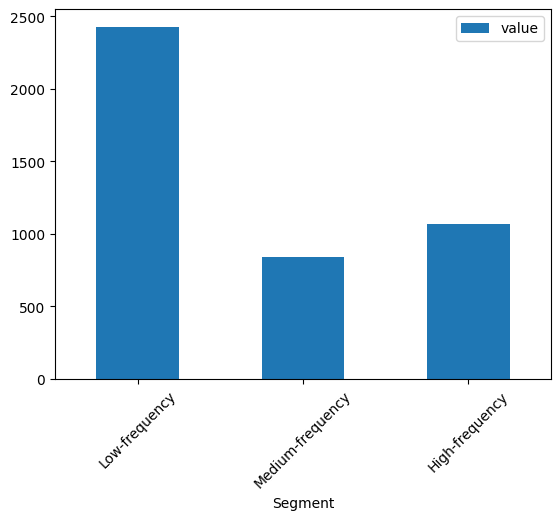

In [59]:
customer_seg_frequency.plot.bar(x='Segment', y='value',rot=45)

### 5.Classification of customers using K-Means 

### Preprocessing Data for Segmentation
The informative features in this dataset that tell us about customer buying behavior include “quantity”, “invoice_date” and “total_cost” Using these variables, we are going to derive a customer’s RFM profile - Recency, Frequency, Monetary Value.

RFM is commonly used in marketing to evaluate a client’s value based on their:
Recency (R): How recently did a particular customer make a purchase?
Frequency (F): How often do they make purchases?
Monetary Value (M): How much money do they spend?

We’ll use the information in the dataset to compute the recency, frequency, and monetary values. Then, we’ll map these values to the generally used RFM score scale of 1 - 5. 

we’ll try to identify customer segments with similar RFM characteristics. And for this, we’ll use K-Means clustering, an unsupervised machine learning algorithm that groups similar data points into clusters.

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391334 entries, 0 to 391333
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoice         391334 non-null  object        
 1   stock_code      391334 non-null  object        
 2   description     391334 non-null  object        
 3   invoice_date    391334 non-null  datetime64[ns]
 4   customer_id     391334 non-null  object        
 5   country         391334 non-null  object        
 6   net_quantity    391334 non-null  float64       
 7   price_per_unit  391334 non-null  float64       
 8   total_cost      391334 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 26.9+ MB


### Compute Recency, Frequency, and Monetary Value

In [61]:
# defining a reference date 'snapshot_date' that’s a day later than the most recent date in the “invoice_date” column:

snapshot_date = max(data['invoice_date']) + pd.DateOffset(days=1)

1.For recency, we’ll calculate the difference between the most recent purchase date and a reference date (snapshot_date). This gives the number of days since the customer's last purchase. 

2.For frequency measures how often a customer makes purchases, we’ll calculate it as the total number of unique invoices or transactions made by each customer.

3.For Monetary value quantifies how much money a customer spends. So we’ll find the average of the total monetary value across transactions.


In [65]:
rfm = data.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice': 'nunique',
    'total_cost': 'sum'
})

In [66]:
# rename the columns for readability
rfm.rename(columns={'invoice_date': 'Recency', 'invoice': 'Frequency', 'total_cost': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
u12346,326,1,0.00
u12347,2,7,4310.00
u12348,75,4,1437.24
u12349,19,1,1457.55
u1235,310,1,294.40


### Map RFM Values onto a 1-5 Scale 
Now let’s map the “Recency”, “Frequency”, and “MonetaryValue” columns to take on values in a scale of 1-5; one of {1,2,3,4,5}.
We’ll essentially assign the values to five different bins, and map each bin to a value. To help us fix the bin edges, let’s use the quantile values of the “Recency”, “Frequency”, and “MonetaryValue” columns:

In [67]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4335.000000,4335.000000,4.335000e+03
mean,92.684890,4.246367,2.264395e+03
std,100.172622,7.643880,2.802611e+04
min,1.000000,1.000000,0.000000e+00
25%,18.000000,1.000000,2.903800e+02
50%,51.000000,2.000000,6.362400e+02
75%,143.000000,5.000000,1.554600e+03
max,374.000000,206.000000,1.761384e+06


In [68]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 300, 600, 2000, 5000, rfm['MonetaryValue'].max()]

Now that we’ve defined the bin edges, let’s map the scores to corresponding labels between 1 and 5 (both inclusive):

In [69]:
# Calculate Recency score based on custom bins 
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

Notice that the R_Score, based on the bins, is 1 for recent purchases 5 for all purchases made over 250 days ago. But we’d like the most recent purchases to have an R_Score of 5 and purchases made over 250 days ago to have an R_Score of 1.

To achieve the desired mapping, we do: 5 - rfm['R_Score'].astype(int) + 1.

Let’s look at the first few rows of the R_Score, F_Score, and M_Score columns:

In [70]:
# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

             R_Score  F_Score  M_Score
customer_id                           
u12346             1        1        1
u12347             5        3        4
u12348             3        3        3
u12349             5        1        3
u1235              1        1        1
u12352             4        3        3
u12353             2        1        1
u12354             2        1        3
u12355             2        1        2
u12356             4        2        4


### Perform K-Means Clustering
K-Means clustering is sensitive to the scale of features. Because the R, F, and M values are all on the same scale, we can proceed to perform clustering without further scaling the features.
Let’s extract the R, F, and M scores to perform K-Means clustering:

In [72]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

we need to find the optimal number of clusters. For this let’s run the K-Means algorithm for a range of K values and use the elbow method to pick the optimal K:

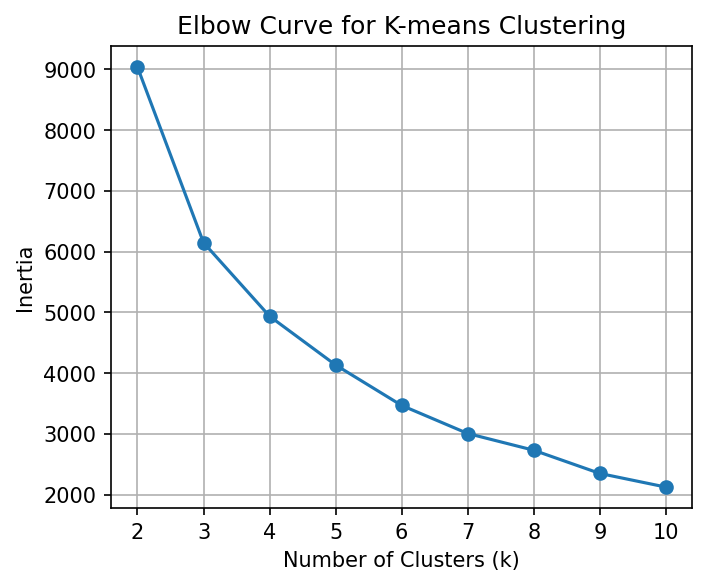

In [76]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5, 4),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

let’s divide the customer base into four segments.
We’ve fixed K to 4. So let’s run the K-Means algorithm to get the cluster assignments for all points in the dataset:

In [77]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

### Interpret the Clusters to Identify Customer Segments 

In [79]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [80]:
cluster_summary

,Cluster,R_Score,F_Score,M_Score
0,0,1.488542,1.055208,1.582292
1,1,3.270492,2.186703,3.097450
2,2,3.870386,1.095160,1.580804
3,3,4.810964,3.227788,3.811909


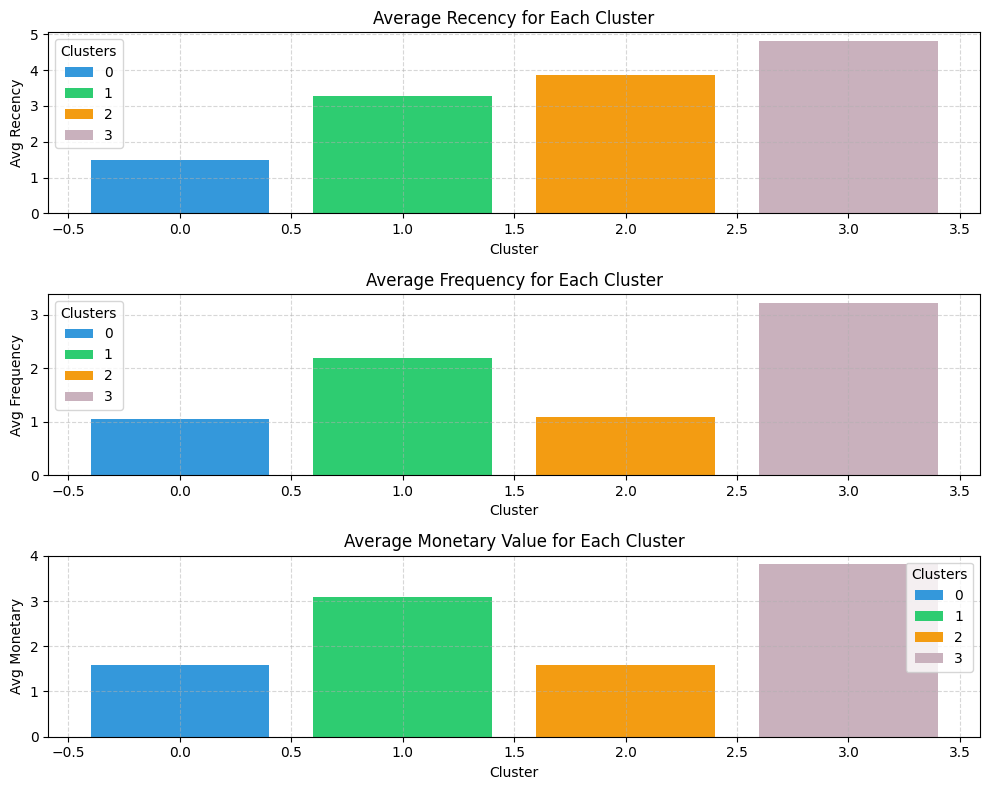

In [81]:
# let's visualise the RFM values 
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=100)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

Cluster 0: This cluster has the lowest recency and moderate frequency, and monetary values.so they are at-Risk customers.

Cluster 1: This cluster is characterized by moderate frequency,recency and monetary values. Let's call them loyal customers.

Cluster 2: This cluster is characterized by high recency and relatively lower frequency and moderate monetary values. So these are recent customers who can potentially become long-term customers.

Cluster 3: Of all the four clusters, this cluster has the highest recency, frequency, and monetary values. Let’s call the customers in this cluster champions.

# 6.Conclusion

1. For Champions: Offer personalized special discounts, early access, and other premium perks to make them feel valued and appreciated.

2. For Loyal Customers: Appreciation campaigns, referral bonuses, and rewards for loyalty.

3. For At-Risk Customers: Re-engagement efforts that include running discounts or promotions to encourage buying.

4. For Recent Customers: Targeted campaigns educating them about the brand and discounts on subsequent purchases. 


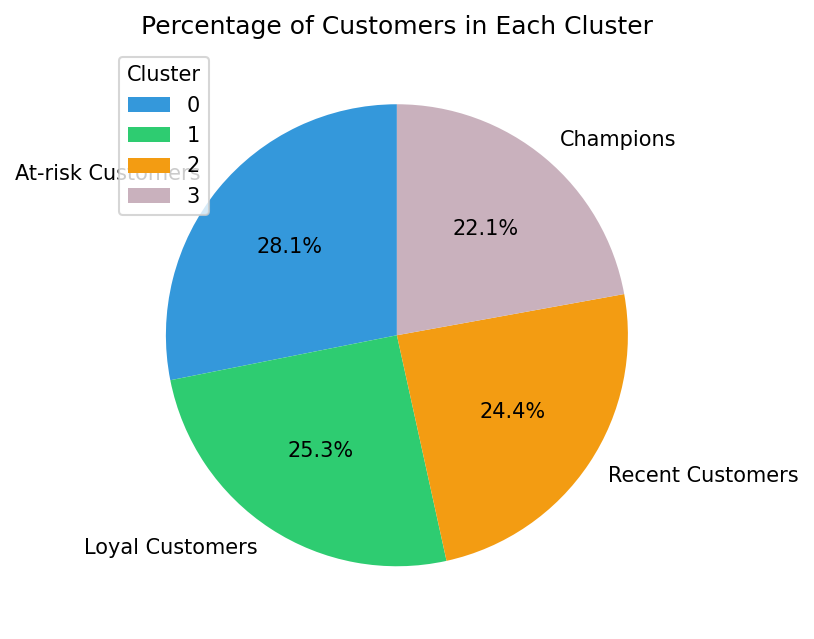

In [83]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['At-risk Customers','Loyal Customers','Recent Customers','Champions']

# Create a pie chart
plt.figure(figsize=(5, 5),dpi=150)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()